In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

## I. Simple Encoder Model

In [2]:
# A separate encoder model

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [3]:
# A separate decoder model

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

* Now we can train our models to reconstruct MNIST digits

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
# note that we are discarding the labels since we are only interested in encoding/decoding the images

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [6]:
# normalize all values between 0-1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [8]:
# training our autoencoder for 50 epochs

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 12s 11ms/step - loss: 0.3846 - val_loss: 0.1936
Epoch 2/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1810 - val_loss: 0.1540
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1498 - val_loss: 0.1338
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1318 - val_loss: 0.1208
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1199 - val_loss: 0.1124
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1121 - val_loss: 0.1063
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1064 - val_loss: 0.1019
Epoch 8/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1025 - val_loss: 0.0989
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0996 - val_loss: 0.0969
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0978 - val_loss: 0.09

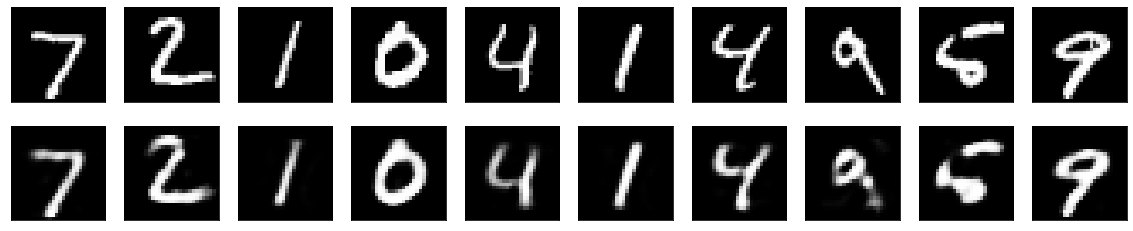

In [9]:
# visualizing the reconstructed inputs and the encoded representations
# Top: original digits / Bottom: reconstructed digits
# Notice the amount of detail lost using this basic approach

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## II. Adding a sparsity constraint on the encoded representations


In [10]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [12]:
# Training the new model for 100 epochs

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 5s 11ms/step - loss: 0.3909 - val_loss: 0.1972
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1873 - val_loss: 0.1617
Epoch 3/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1579 - val_loss: 0.1428
Epoch 4/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1408 - val_loss: 0.1315
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1305 - val_loss: 0.1239
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1236 - val_loss: 0.1186
Epoch 7/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1187 - val_loss: 0.1143
Epoch 8/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1145 - val_loss: 0.1113
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1120 - val_loss: 0.1091
Epoch 10/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1096 -

Epoch 81/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0972 - val_loss: 0.0963
Epoch 82/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0973 - val_loss: 0.0963
Epoch 83/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0973 - val_loss: 0.0962
Epoch 84/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0973 - val_loss: 0.0962
Epoch 85/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0971 - val_loss: 0.0962
Epoch 86/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0971 - val_loss: 0.0961
Epoch 87/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0969 - val_loss: 0.0961
Epoch 88/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0972 - val_loss: 0.0961
Epoch 89/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0971 - val_loss: 0.0961
Epoch 90/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0969

## III. Deep Autoencoder

In [15]:
# stacks of layers are used in the encoder instead of a single layer

input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [16]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 5s 12ms/step - loss: 0.3404 - val_loss: 0.1723
Epoch 2/100
235/235 [==============================] - 2s 11ms/step - loss: 0.1631 - val_loss: 0.1431
Epoch 3/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1413 - val_loss: 0.1327
Epoch 4/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1312 - val_loss: 0.1219
Epoch 5/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1216 - val_loss: 0.1159
Epoch 6/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1160 - val_loss: 0.1116
Epoch 7/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1127 - val_loss: 0.1090
Epoch 8/100
235/235 [==============================] - 4s 17ms/step - loss: 0.1096 - val_loss: 0.1067
Epoch 9/100
235/235 [==============================] - 3s 11ms/step - loss: 0.1075 - val_loss: 0.1046
Epoch 10/100
235/235 [==============================] - 3s 11ms/step - loss: 0.105

235/235 [==============================] - 3s 11ms/step - loss: 0.0868 - val_loss: 0.0865
Epoch 81/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0864 - val_loss: 0.0866
Epoch 82/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0867 - val_loss: 0.0864
Epoch 83/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0865 - val_loss: 0.0868
Epoch 84/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0865 - val_loss: 0.0866
Epoch 85/100
235/235 [==============================] - 2s 11ms/step - loss: 0.0866 - val_loss: 0.0863
Epoch 86/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0865 - val_loss: 0.0864
Epoch 87/100
235/235 [==============================] - 2s 11ms/step - loss: 0.0865 - val_loss: 0.0863
Epoch 88/100
235/235 [==============================] - 2s 11ms/step - loss: 0.0866 - val_loss: 0.0862
Epoch 89/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0863 - 

## IV. Convolutional autoencoder

* The encoder will consist in a stack of *Conv2D* and *MaxPooling2D* layers 
* The decoder will consist in a stack of *Conv2D* and *UpSampling2D* layers.

In [17]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# To train it, the original MNIST digits with shape (samples, 3, 28, 28) is used
# pixel values will be normalized between 0 and 1
# Let's train this model for 50 epochs

from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [21]:
# we can monitor training using the TensorBoard web interface

from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 16s 24ms/step - loss: 0.3015 - val_loss: 0.1434
Epoch 2/50
469/469 [==============================] - 10s 22ms/step - loss: 0.1379 - val_loss: 0.1232
Epoch 3/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1212 - val_loss: 0.1132
Epoch 4/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1132 - val_loss: 0.1089
Epoch 5/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1096 - val_loss: 0.1058
Epoch 6/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1069 - val_loss: 0.1041
Epoch 7/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1051 - val_loss: 0.1023
Epoch 8/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1032 - val_loss: 0.1011
Epoch 9/50
469/469 [==============================] - 10s 21ms/step - loss: 0.1022 - val_loss: 0.1000
Epoch 10/50
469/469 [==============================] - 10s 21ms/step - loss: 0.101

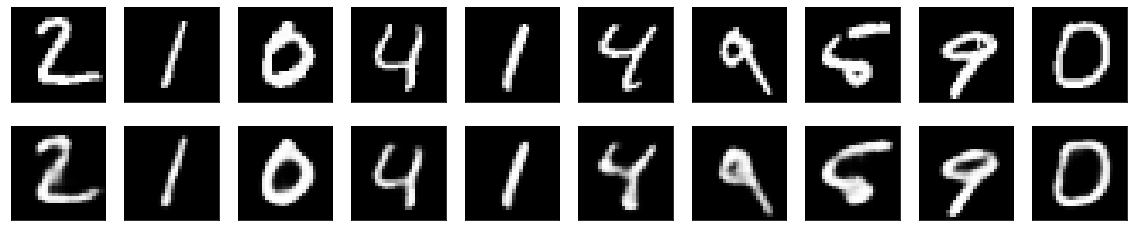

In [22]:
# A look at the reconstructed digits

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

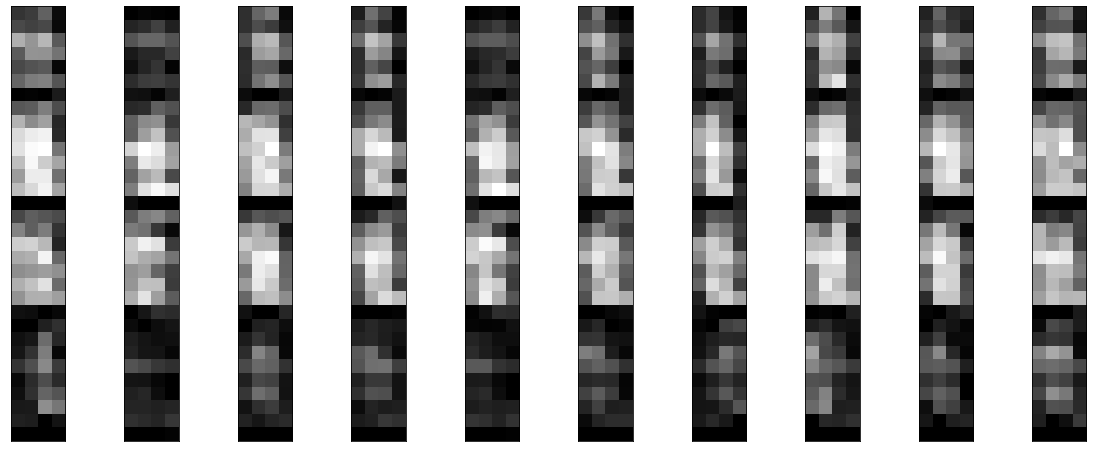

In [23]:
# Looking at the 128-dimensional encoded representations

encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## V. Application to image denoising


In [24]:
# generate synthetic noisy digits by applying a gaussian noise matrix and clipping the images between 0 and 1

from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

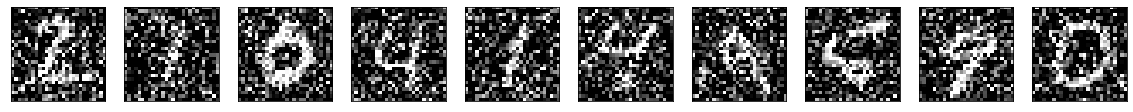

In [25]:
# Here is what the noisy digits look like

n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
# Our model with a few more filters per layer

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [27]:
# Let's train it for 100 epochs

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 15s 27ms/step - loss: 0.2501 - val_loss: 0.1196
Epoch 2/100
469/469 [==============================] - 10s 22ms/step - loss: 0.1177 - val_loss: 0.1101
Epoch 3/100
469/469 [==============================] - 12s 22ms/step - loss: 0.1099 - val_loss: 0.1057
Epoch 4/100
469/469 [==============================] - 12s 26ms/step - loss: 0.1056 - val_loss: 0.1027
Epoch 5/100
469/469 [==============================] - 12s 25ms/step - loss: 0.1030 - val_loss: 0.1014
Epoch 6/100
469/469 [==============================] - 10s 22ms/step - loss: 0.1015 - val_loss: 0.1001
Epoch 7/100
469/469 [==============================] - 12s 25ms/step - loss: 0.1005 - val_loss: 0.0995
Epoch 8/100
469/469 [==============================] - 12s 25ms/step - loss: 0.0997 - val_loss: 0.0985
Epoch 9/100
469/469 [==============================] - 11s 23ms/step - loss: 0.0989 - val_loss: 0.0983
Epoch 10/100
469/469 [==============================] - 12s 25ms/step - l

Epoch 80/100
469/469 [==============================] - 12s 25ms/step - loss: 0.0933 - val_loss: 0.0936
Epoch 81/100
469/469 [==============================] - 12s 26ms/step - loss: 0.0933 - val_loss: 0.0934
Epoch 82/100
469/469 [==============================] - 10s 22ms/step - loss: 0.0931 - val_loss: 0.0934
Epoch 83/100
469/469 [==============================] - 12s 25ms/step - loss: 0.0932 - val_loss: 0.0934
Epoch 84/100
469/469 [==============================] - 12s 25ms/step - loss: 0.0932 - val_loss: 0.0935
Epoch 85/100
469/469 [==============================] - 11s 22ms/step - loss: 0.0932 - val_loss: 0.0934
Epoch 86/100
469/469 [==============================] - 12s 22ms/step - loss: 0.0930 - val_loss: 0.0937
Epoch 87/100
469/469 [==============================] - 12s 26ms/step - loss: 0.0932 - val_loss: 0.0937
Epoch 88/100
469/469 [==============================] - 12s 26ms/step - loss: 0.0932 - val_loss: 0.0934
Epoch 89/100
469/469 [==============================] - 11s 23ms

## Variational autoencoder (VAE)


In [28]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [29]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [30]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [31]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [34]:
# Training VAE on MNIST digits

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.2921 - val_loss: 147.0097
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.2488 - val_loss: 147.1799
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.2594 - val_loss: 146.9381
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.2346 - val_loss: 146.7022
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.1838 - val_loss: 147.2416
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 144.1799 - val_loss: 146.9824
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.1454 - val_loss: 146.9230
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.1560 - val_loss: 146.8204
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.0975 - val_loss: 147.3259
Epoch 10/100
1875/1875 [=============

Epoch 77/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.7405 - val_loss: 146.4774
Epoch 78/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.7373 - val_loss: 146.5971
Epoch 79/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.6870 - val_loss: 146.7318
Epoch 80/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.7077 - val_loss: 146.4670
Epoch 81/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.6684 - val_loss: 146.5392
Epoch 82/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.6662 - val_loss: 146.6255
Epoch 83/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.6197 - val_loss: 146.4142
Epoch 84/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.6333 - val_loss: 146.5142
Epoch 85/100
1875/1875 [==============================] - 8s 4ms/step - loss: 142.6144 - val_loss: 146.5003
Epoch 86/100
1875/1875 [====

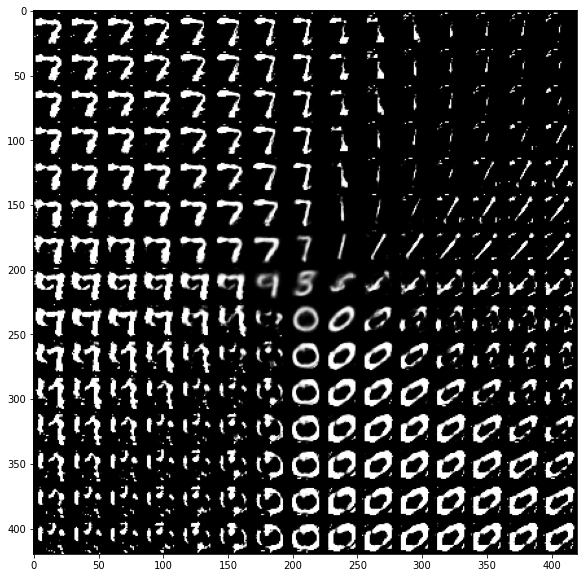

In [38]:
# Scanning the latent plane, sampling latent points at regular intervals, and generating the corresponding digit 
# for each of these points.

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()